## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:15<00:00, 24.0MB/s]
100% 331M/331M [00:15<00:00, 22.0MB/s]


In [4]:
!unzip utkface-new.zip -d /content/utkface/
BASE_DIR = '/content/utkface/UTKFace'

Streaming output truncated to the last 5000 lines.
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: /content/utkface/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  in

In [5]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/utkface/UTKFace/16_0_0_20170110232444...,16,0
1,/content/utkface/UTKFace/20_1_1_20170112231738...,20,1
2,/content/utkface/UTKFace/52_0_3_20170119200211...,52,0
3,/content/utkface/UTKFace/3_0_2_201612191602595...,3,0
4,/content/utkface/UTKFace/35_0_0_20170116193236...,35,0


In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

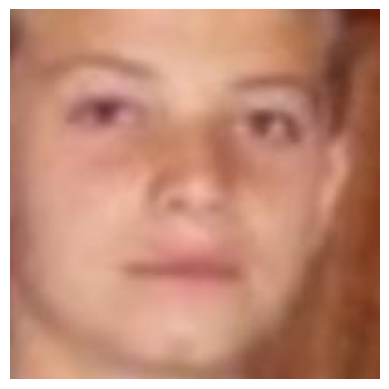

In [8]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

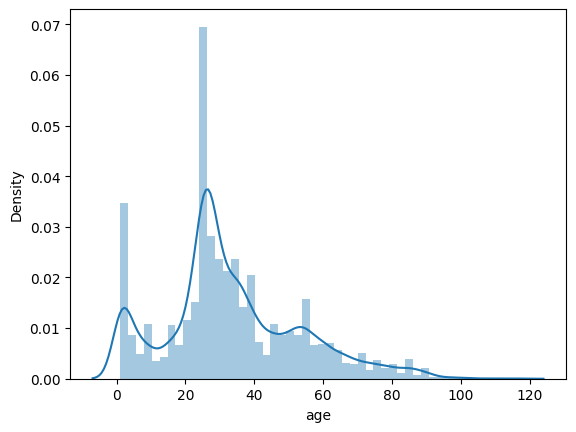

In [9]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

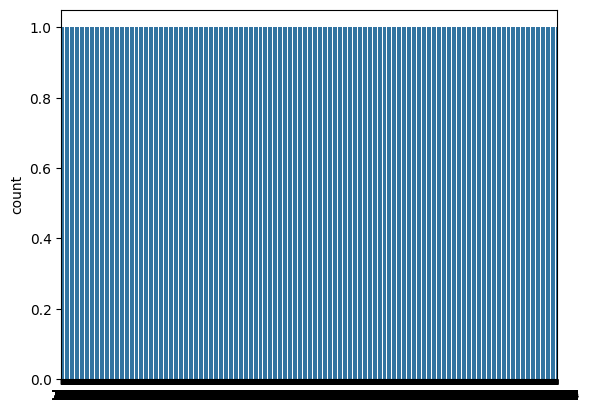

In [10]:
sns.countplot(df['gender'])

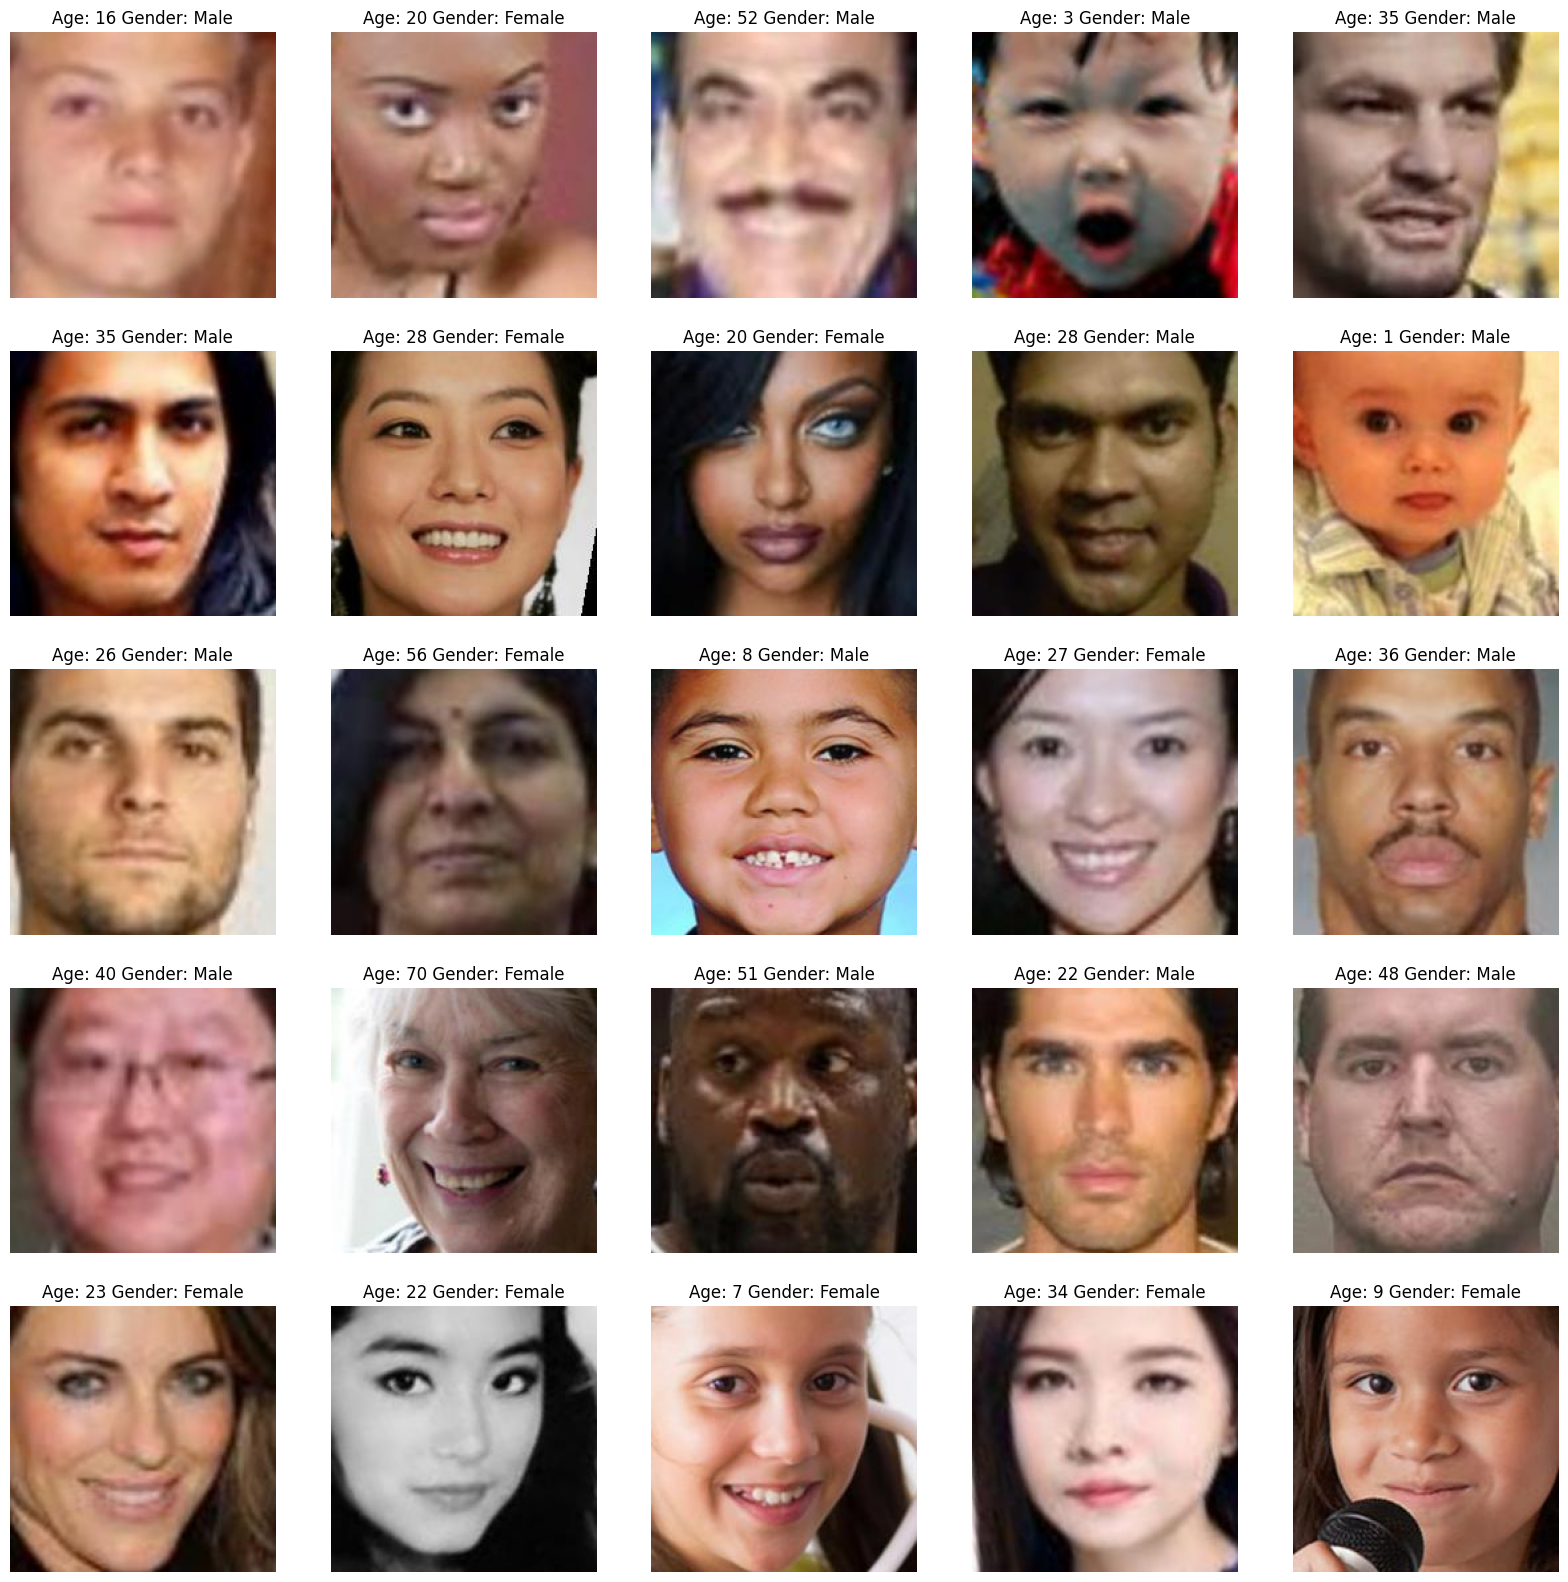

In [11]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [17]:
from PIL import Image
from tqdm import tqdm
import numpy as np
from keras.preprocessing.image import load_img

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        # Use Image.Resampling.LANCZOS instead of Image.ANTIALIAS
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [18]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:26<00:00, 893.99it/s] 


In [19]:
X.shape

(23708, 128, 128, 1)

In [20]:
# normalize the images
X = X/255.0

In [21]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [22]:
input_shape = (128, 128, 1)

## Model Creation

In [23]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

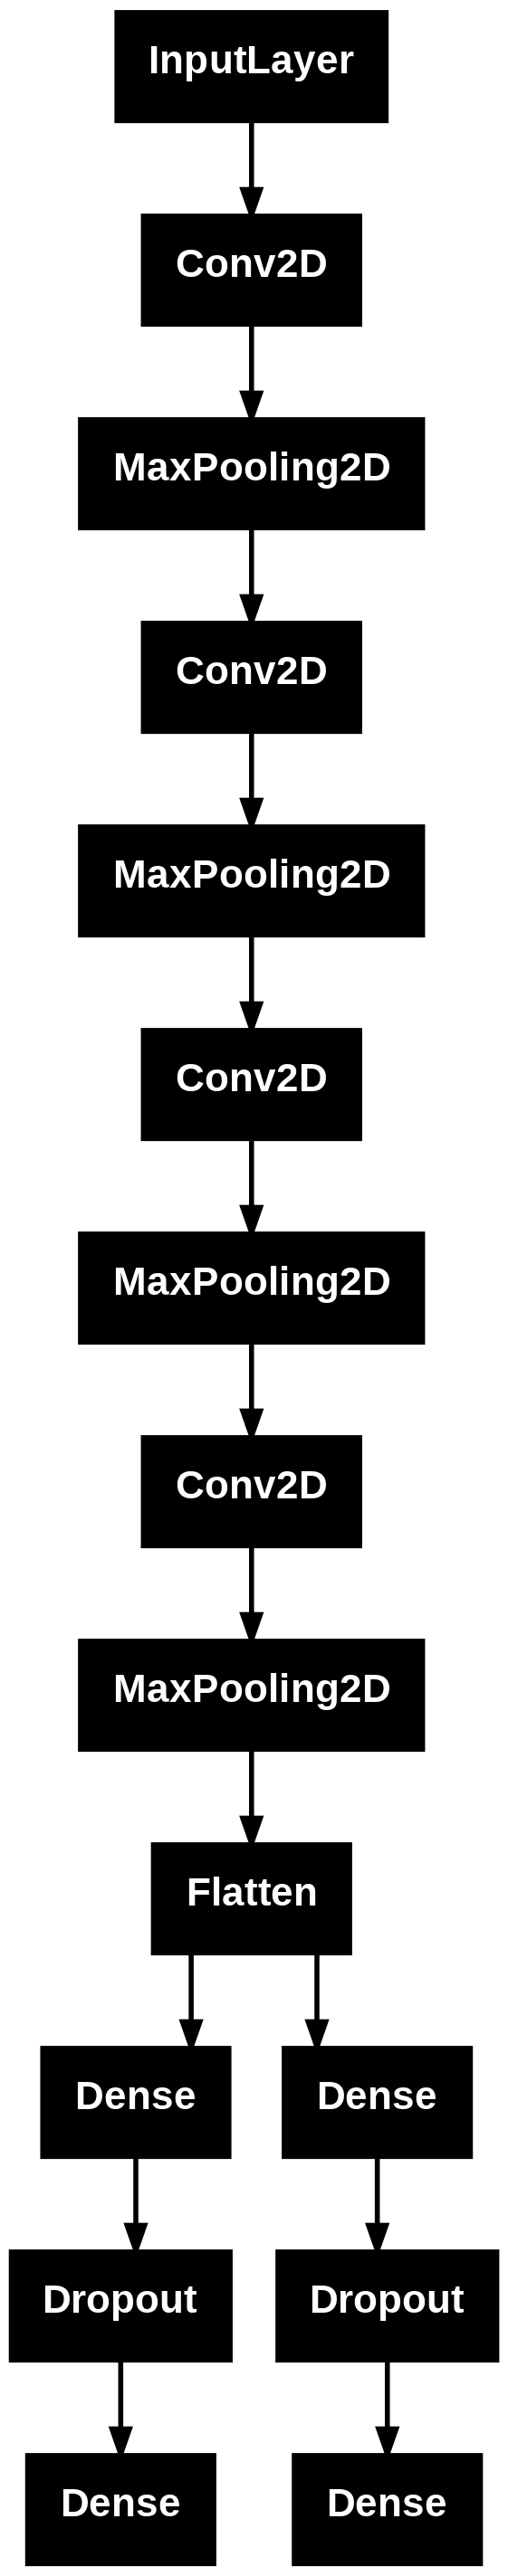

In [24]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - age_out_loss: 16.4751 - age_out_mae: 16.4751 - gender_out_accuracy: 0.5256 - gender_out_loss: 0.7255 - loss: 17.2006 - val_age_out_loss: 11.5171 - val_age_out_mae: 11.5082 - val_gender_out_accuracy: 0.7417 - val_gender_out_loss: 0.5341 - val_loss: 12.0428
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_loss: 11.6268 - age_out_mae: 11.6268 - gender_out_accuracy: 0.7533 - gender_out_loss: 0.5080 - loss: 12.1348 - val_age_out_loss: 9.6983 - val_age_out_mae: 9.6925 - val_gender_out_accuracy: 0.8030 - val_gender_out_loss: 0.4159 - val_loss: 10.1089
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - age_out_loss: 9.9426 - age_out_mae: 9.9426 - gender_out_accuracy: 0.8119 - gender_out_loss: 0.4025 - loss: 10.3452 - val_age_out_loss: 8.3824 - val_age_out_mae: 8.3797 - val_gender_out_accuracy: 0.8330 - val_gender_out_loss: 0.3612 - val_loss: 8.7414
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - age_out_loss: 8

## Plot the Results

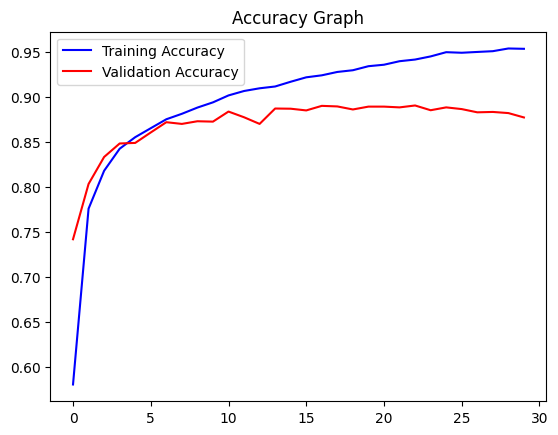

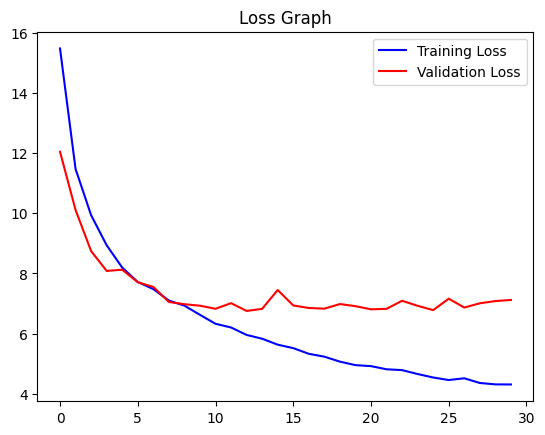

In [26]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

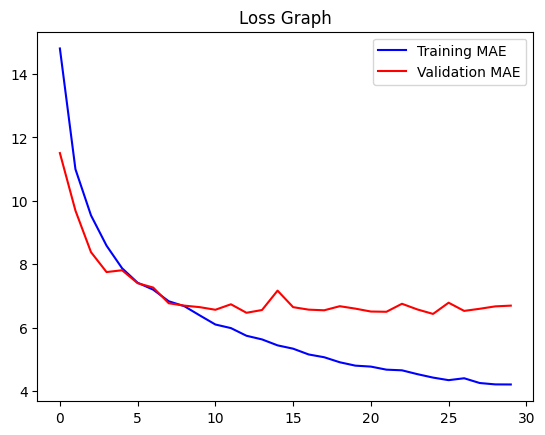

In [27]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Male Original Age: 34
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
Predicted Gender: Male Predicted Age: 28


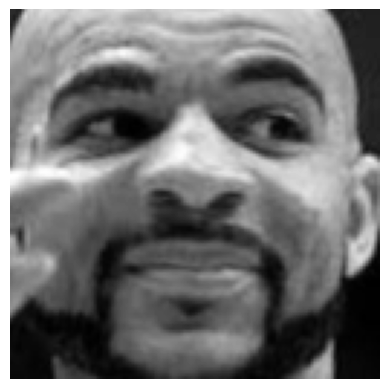

In [28]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Male Predicted Age: 20


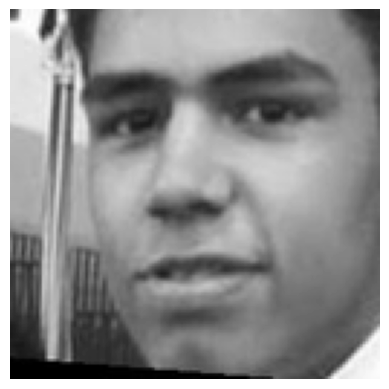

In [29]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Gender: Male Predicted Age: 34


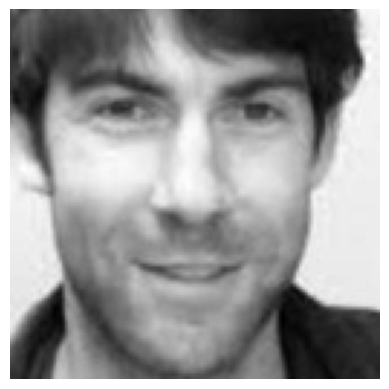

In [30]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');